##Análise de Vendas e impacto dos preços e promoções sobre essas vendas. 
O trabalho se propõe a analisar o dataset exportado do site Kaggle.com, DT MART: Market Mix Modeling.
Esse dataset é um conjunto de dados que simula as informações de vendas, preço, promoções, concorrência e investimentos em marketing de uma rede varejista fictícia chamada DT Mart. 

Como a base é dividida em múltiplas tabelas, ele atende aos requisitos da atividade, pois possibilita a construção de pipelines de ingestão, limpeza, transformação, modelagem analítica e análises temporais utilizando o Databricks

## Introdução
Para este trabalho, foi selecionado o dataset DT MART: Market Mix Modeling, disponibilizado publicamente no Kaggle. Trata-se de um conjunto de dados sintético, porém realista, que simula o desempenho de vendas de uma rede varejista fictícia (DT Mart) ao longo do tempo, incluindo variáveis relacionadas a preços, investimentos em mídia, promoções, concorrência e volume de vendas.

A escolha deste conjunto de dados se justifica porque ele permite trabalhar todos os pilares essenciais de um projeto de Engenharia de Dados: ingestão, modelagem, qualidade de dados, construção de pipelines e análise orientada à solução de problemas. Além disso, o dataset possui estrutura temporal consistente e diferentes dimensões de negócio, possibilitando a criação de um Data Warehouse em esquema estrela e permitindo análises de vendas, comportamento de preços e impactos de campanhas promocionais — exatamente como proposto nos objetivos deste estudo.

Dessa forma, ao longo deste trabalho será apresentado todo o ciclo de Engenharia de Dados aplicado ao dataset, incluindo as etapas de coleta, modelagem, carga, qualidade de dados e análises exploratórias e explicativas, demonstrando como organizar e preparar dados para suportar decisões comerciais baseadas em evidências.

# Documentação da origem dos dados

- Fonte: Kaggle.com  
- Dataset: DT MART - Market Mix Modeling  
- Link de origem: https://www.kaggle.com/datasets/datatattle/dt-mart-market-mix-modeling/data 
- Data de download: 30/11/2025  
- Responsabilidade ética: dados públicos, sem restrição de scraping ou uso.

### Passos:
1. Download manual do Kaggle para o computador.
2. Upload manual para o Databricks: "Data" > "Upload" > "DBFS FileStore".
3. Registro dos arquivos como tabelas no catálogo workspace.default.

### Modelagem de Dados
O modelo de dados adotado neste trabalho é o Esquema Estrela, amplamente utilizado em projetos de Data Warehouse voltados à análise de dados analíticos e tomada de decisão. A escolha deste modelo se justifica pela sua simplicidade estrutural, alta performance em consultas analíticas e facilidade de compreensão por usuários de negócio. O dataset DT MART apresenta uma estrutura naturalmente compatível com este tipo de modelagem, pois possui um conjunto bem definido de métricas de vendas, que podem ser organizadas em uma Tabela Fato, além de diferentes perspectivas de análise representadas por Tabelas Dimensão, como produto, tempo, promoções e investimentos em mídia.

## O que esse trabalho se propõe a analisar: 
Através do Dataset em questão, quero fazer uma análise de vendas por meio de uma série temporal de vendas ao longo de semanas e meses, também quero identificar se existe tendências e sazonalidade e, através das campanhas de vendas, fazer uma comparação das vendas antes e depois das mesmas. 

### Camada Bronze – Dados Brutos
A Camada Bronze representa a primeira etapa da arquitetura de dados adotada neste projeto, sendo responsável pelo armazenamento dos dados brutos exatamente como foram obtidos da fonte original, sem qualquer tipo de transformação semântica ou tratamento de qualidade.

No presente trabalho, a Camada Bronze é composta pelos arquivos CSV originais do dataset DT MART: Market Mix Modeling, que foram baixados manualmente do Kaggle e carregados no ambiente Databricks por meio da funcionalidade de upload para o DBFS (Databricks File System). Durante este processo, os arquivos foram automaticamente registrados como tabelas Delta no Unity Catalog, preservando integralmente o conteúdo original dos dados.


In [0]:
# 2. Carregamento dos dados e ingestão de dados
# Comentário: Ao carregar os meus arquivos (no dataset escolhido eu tenho sete) o Databricks criou tabelas automaticamente no unity catalog. Os arquivos foram convertidos para tabelas Delta e armazenados em um local storage do catalago. Esse processo culminou que eu fizesse dois passos do trabalho, o carregamento e a ingestão de dados. 

# =====================================================
# A seguir elaboro a camada bronze do presente trabalho
# =====================================================

firstfile = spark.table("workspace.default.firstfile")
media_investment = spark.table("workspace.default.media_investment")
monthly_np_sscore = spark.table("workspace.default.monthly_np_sscore")
product_list = spark.table("workspace.default.product_list")
sales = spark.table("workspace.default.sales")
secondfile = spark.table("workspace.default.secondfile")
special_sale = spark.table("workspace.default.special_sale")


In [0]:
# Configuração do Ambiente
# Importação das bibliotecas necessárias

import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col, split, to_date, year, month, when, lit, coalesce, date_format, regexp_replace, to_timestamp, trim, isnull, dayofweek, dayofyear, weekofyear, quarter, monotonically_increasing_id
from pyspark.sql.functions import min, max, countDistinct
from pyspark.sql import Row
from pyspark.sql.functions import collect_set
from pyspark.sql.functions import count, isnan
from pyspark.sql.functions import round
from functools import reduce
import matplotlib.pyplot as plt




# Tabela Fato – Fato_Vendas

A Tabela Fato central do modelo Estrela é denominada Fato_Vendas. Ela representa o nível mais granular das transações de venda da rede varejista fictícia DT Mart, contendo as principais métricas quantitativas do negócio.

A granularidade da tabela é definida como:
"Uma linha por produto, por data, por canal de venda."

Essa definição permite análises temporais, avaliação de impacto de preço, elasticidade da demanda, efeito de promoções e retorno sobre investimento em mídia.

A Tabela Fato foi construída a partir da integração das tabelas de vendas, promoções, investimentos em mídia, concorrência e indicadores mensais de participação de mercado. Sua principal função é centralizar as métricas quantitativas do negócio, permitindo análises comparativas ao longo do tempo, avaliações de impacto de preço, sensibilidade da demanda e eficiência das ações promocionais.

A tabela possui métricas diretas, como quantidade vendida e preço, além de métricas derivadas, como a receita, calculada a partir da multiplicação entre o volume vendido e o preço unitário. Também foram incorporados indicadores de contexto, como a existência de promoção, valor de desconto, investimentos em mídia e preço do concorrente, enriquecendo as análises de desempenho comercial.

A granularidade da Tabela Fato é definida no nível diário por produto, garantindo consistência para análises temporais, permitindo agregações por semana, mês, trimestre e ano, além de facilitar comparações entre períodos promocionais e não promocionais.




##Documentação dos problemas/erros e solução aplicaicada na contrução do pipeline ETL.
1. **Erros de nome de coluna e linhagem de dados:**

Estes erros surgiram porque o PySpark não conseguia encontrar as colunas no DataFrame, devido ao método de importação do Databricks e à limpeza inadequada das colunas intermediárias.

Problema 1: 
- Descrição do problema: O Databricks, ao importar o arquivo CSV sem cabeçalho, leu todos os dados como uma única coluna string. 
- Solução: Usar o método sales.columns[0] para obter o nome exato da coluna string e usar esta variável no split(col(...)).

Problema 2
- Descrição do problema: Ocorreu durante o join com market_score. O erro real era um conflito de linhagem de dados: a coluna original ID_Item_ordered existia lado a lado com a coluna limpa product_id.
- Solução: Aplicar um .select() logo após a transformação inicial da sales_trf para descartar explicitamente todas as colunas originais e manter apenas as colunas limpas (sale_date, product_id, etc.).

2. **Erros de Parsing e Formato de Data/Tempo**

Estes erros surgiram porque o Spark não conseguia interpretar o valor da data em string como um objeto de data/tempo válido.

Problema 1: 
- Descrição do problema: Falha ao converter a data t17-10-2015 15:11 para um tipo DATE. A string continha um prefixo indesejado (t) e a função to_date não era robusta o suficiente. 
- Solução: Usar a sequência de funções: regexp_replace (para remover o prefixo 't'), seguido por to_timestamp(..., "dd-MM-yyyy HH:mm") (para ler o tempo corretamente), e, finalmente, .cast("date") para manter apenas a data.

3. **Erros de Tipagem e Dados Malformados**

Problema 1: 
- Descrição do problema: O ID do produto (ID_Item_ordered) estava em notação científica (E+15), e o número era muito grande para caber em um INT padrão.
- Solução: Usar uma conversão em duas etapas: .cast("double").cast("long"). Isso força o Spark a interpretar a notação científica como um número de ponto flutuante antes de convertê-lo para o tipo LONG (BIGINT), que suporta IDs grandes.

Problema 2: 
- Descrição do problema: Ocorreu em colunas métricas (revenue, NPS, Total Investment) quando o Spark encontrou uma string vazia/apenas espaços em branco (' ') ao tentar converter para DOUBLE.
- Solução: Implementar a função auxiliar safe_cast (usando when e trim) para checar e substituir strings vazias por NULL antes da conversão de tipo. Isso garante que o cast só seja aplicado a valores válidos.

Problema 3: 
- Descrição do problema: Tentei usar o método try_cast para tolerar os valores malformados, mas a versão do PySpark no seu ambiente Databricks não suportava esta função.
- Solução: Retroceder para a limpeza explícita usando when/trim (safe_cast), garantindo compatibilidade com todas as versões do Spark.

## Inspeção e Diagnóstico dos dados
O Pipeline da ETL estava quebrando muito e com o intuito de antecipar e corrigir os problemas de qualidade e formato dos dados eu executei os comandos spark.table(), printSchema(), e head(1) para cada uma de suas cinco tabelas de origem, buscamos três informações cruciais:
1. Carregar os Dataframes:

    A linha sales = spark.table("workspace.default.sales") carrega os dados brutos de cada tabela de origem no formato de DataFrame do Spark. Esta é a fase de Extração (E) do ETL, onde tornamos os dados acessíveis para processamento.

2. Inspecionar a estrutura:

    O comando printSchema() revela o nome exato das colunas e o tipo de dado (Schema) que o Spark detectou na extração. 
  - Importância: Isso confirmou que as tabelas sales e products foram lidas como uma única coluna string (o que chamamos de "Coluna Única"), enquanto as outras tabelas foram lidas corretamente com múltiplas colunas.
  
3. Visualizar uma amostra:

    O comando head(1) retorna a primeira linha de dados de cada tabela.
  - Importância: Esta amostra revelou o conteúdo da coluna string única (incluindo o delimitador \t e prefixos como o t na data), permitindo identificar os índices de coluna corretos para o split() e os erros de formato (como a notação científica E+15 nos IDs e a string vazia ' ' nos valores numéricos).

In [0]:
# Tabela de Vendas
sales = spark.table("workspace.default.sales")
print("--- Sales Schema ---")
sales.printSchema()
print("\n--- Sales Head (1 linha) ---")
sales.head(1)

--- Sales Schema ---
root
 |-- ID\tDate\tID_Order\tID_Item_ordered\tGMV\tUnits_sold\tSLA\tProduct_Category\tAnalytic_Category\tSub_category\tproduct_analytic_vertical\tMRP\tProcurement_SLA: string (nullable = true)


--- Sales Head (1 linha) ---


[Row(ID	Date	ID_Order	ID_Item_ordered	GMV	Units_sold	SLA	Product_Category	Analytic_Category	Sub_category	product_analytic_vertical	MRP	Procurement_SLA='AUDEA8VKC6JHYRQV\t03-01-2016 13:17\t1.49E+15\t1.49E+15\t3699\t1\t7\tCE\tEntertainmentSmall\tAudioMP3Player\tAudioMP3Player\t4300\t5')]

In [0]:
# Tabela de Produtos (Dimensão)
products = spark.table("workspace.default.product_list")
print("--- Products Schema ---")
products.printSchema()
print("\n--- Products Head (1 linha) ---")
products.head(1)

--- Products Schema ---
root
 |-- Product: string (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- Percent: double (nullable = true)


--- Products Head (1 linha) ---


[Row(Product='\\N', Frequency='5828', Percent=0.4)]

In [0]:
# Tabela de Concorrência
competitor = spark.table("workspace.default.firstfile")
print("--- Competitor Schema ---")
competitor.printSchema()
print("\n--- Competitor Head (1 linha) ---")
competitor.head(1)

--- Competitor Schema ---
root
 |-- Date: date (nullable = true)
 |-- Sales_name: string (nullable = true)
 |-- gmv_new: double (nullable = true)
 |-- units: long (nullable = true)
 |-- product_mrp: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- product_category: string (nullable = true)
 |-- product_subcategory: string (nullable = true)
 |-- product_vertical: string (nullable = true)


--- Competitor Head (1 linha) ---


[Row(Date=datetime.date(2016, 5, 10), Sales_name='No Promotion', gmv_new=1749.0, units=1, product_mrp=2990.0, discount=1241.0, product_category='GamingHardware', product_subcategory='GamingConsole', product_vertical='HandheldGamingConsole')]

In [0]:
# Tabela de Investimento em Mídia
media = spark.table("workspace.default.media_investment")
print("--- Media Schema ---")
media.printSchema()
print("\n--- Media Head (1 linha) ---")
media.head(1)

--- Media Schema ---
root
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- Total Investment: double (nullable = true)
 |-- TV: double (nullable = true)
 |-- Digital: double (nullable = true)
 |-- Sponsorship: double (nullable = true)
 |-- Content Marketing: double (nullable = true)
 |-- Online marketing: double (nullable = true)
 |--  Affiliates: double (nullable = true)
 |-- SEM: double (nullable = true)
 |-- Radio: double (nullable = true)
 |-- Other: double (nullable = true)


--- Media Head (1 linha) ---


[Row(Year=2015, Month=7, Total Investment=17.1, TV=0.2, Digital=2.5, Sponsorship=7.4, Content Marketing=0.0, Online marketing=1.3,  Affiliates=0.5, SEM=5.0, Radio=None, Other=None)]

In [0]:
# Tabela de Market Score
market_score = spark.table("workspace.default.monthly_np_sscore")
print("--- Market Score Schema ---")
market_score.printSchema()
print("\n--- Market Score Head (1 linha) ---")
market_score.head(1)

--- Market Score Schema ---
root
 |-- Date: string (nullable = true)
 |-- NPS: double (nullable = true)


--- Market Score Head (1 linha) ---


[Row(Date='7/1/2015', NPS=54.6)]

### Camada Prata e Camada Ouro
A seguir no código temos o começo da camada prata, tal como a transição para a camada ouro.

### Camada Prata
A Camada Prata representa a etapa intermediária da arquitetura de dados adotada neste projeto, sendo responsável pelo tratamento, padronização, validação e enriquecimento dos dados oriundos da Camada Bronze. Nesta camada, os dados brutos passam por processos de transformação que visam torná-los semanticamente corretos, tecnicamente consistentes e prontos para integração analítica.

No presente trabalho, a Camada Prata foi implementada por meio de pipelines de ETL desenvolvidos em PySpark no Databricks, contemplando as etapas de inspeção estrutural, limpeza, tipagem, parsing de datas, tratamento de valores malformados e conciliação de múltiplas fontes de dados.

O que caracteriza essa parte do código ser a camada prata: Parsing, limpeza, tipagem, enriquecimento e joins

### Camada Ouro
A Camada Ouro representa a camada final da arquitetura de dados adotada neste projeto, sendo responsável pela disponibilização dos dados com semântica de negócio, alta confiabilidade e estrutura analítica adequada para consumo por usuários, análises exploratórias e suporte à tomada de decisão.

Nesta camada, os dados previamente tratados e conformados na Camada Prata são persistidos como tabelas Delta oficiais no Unity Catalog, organizadas segundo o modelo dimensional Esquema Estrela, composto por uma Tabela Fato central e suas respectivas Tabelas Dimensão.

A Camada Ouro consolida regras de negócio, padroniza métricas e garante integridade analítica, permitindo que as informações estejam prontas para agregações, análises temporais, avaliações comparativas e geração de insights. Diferentemente das camadas anteriores, a Camada Ouro não realiza correções estruturais ou limpeza técnica, mas se concentra exclusivamente na organização analítica, governança e consumo dos dados.

O que caracteriza essa parte do código ser a camada ouro: Persistência física, Tabela Delta, nome de negócio (Fato_vendas_dw), Semântica analítica

Fazem parte da cmada ouro:fato_vendas_dw, dim_produto_dw, dim_tempo_dw e catalogo_*.  

As duas camadas podem ser observadas abaixo:

In [0]:
# Pipeline ETL – Construção da Tabela Fato_Vendas

# ================================================================
# Camada Prata – Pipeline ETL para Conformação dos Dados de Vendas
# ================================================================

### Etapa 1 – Extração dos Dados
sales = spark.table("workspace.default.sales")
promos = spark.table("workspace.default.special_sale")
media = spark.table("workspace.default.media_investment")
competitor = spark.table("workspace.default.firstfile")
market_score = spark.table("workspace.default.monthly_np_sscore")

# --- Função Auxiliar de Limpeza ---
# Esta função substitui valores nulos, strings vazias ou strings de espaço por NULL.
# Isso é crucial para que o cast("double") não quebre.
def safe_cast(coluna, novo_tipo):
    return when(
        (isnull(coluna)) | (trim(coluna) == ""), 
        lit(None)
    ).otherwise(
        coluna.cast(novo_tipo)
    )

# 1. TRATAMENTO E PARSING da Tabela SALES (Col. Única com delimitador \t)
coluna_unica_sales = sales.columns[0]

sales_parsed = sales.select(
    split(col(coluna_unica_sales), '\t').getItem(1).alias("Full_Date_Time"), 
    split(col(coluna_unica_sales), '\t').getItem(3).alias("ID_Item_ordered"), 
    split(col(coluna_unica_sales), '\t').getItem(4).alias("GMV"),             
    split(col(coluna_unica_sales), '\t').getItem(5).alias("Units_sold"),      
    split(col(coluna_unica_sales), '\t').getItem(11).alias("MRP")             
)

# 2. CONVERSÃO DE TIPOS E LIMPEZA DA FATO
sales_trf = sales_parsed \
    .withColumn("Clean_Date_Time", regexp_replace(col("Full_Date_Time"), "^t", "")) \
    .withColumn("sale_timestamp", to_timestamp(col("Clean_Date_Time"), "dd-MM-yyyy HH:mm")) \
    .withColumn("sale_date", col("sale_timestamp").cast("date")) \
    .withColumn("product_id", safe_cast(col("ID_Item_ordered").cast("double"), "long")) \
    .withColumn("units_sold", safe_cast(col("Units_sold"), "int")) \
    .withColumn("revenue", safe_cast(col("GMV"), "double")) \
    .withColumn("product_mrp", safe_cast(col("MRP"), "double")) \
    .withColumn("year", year(col("sale_date"))) \
    .withColumn("month", month(col("sale_date"))) \
    .select( 
        "sale_date", "product_id", "units_sold", "revenue", "product_mrp", "year", "month"
    )


### Etapa 2 – Transformações e Joins

# 3. TRATAMENTO: Tabela PROMOS (special_sale)
promos_flag = promos.select(
    to_date(col("Date")).alias("promo_date")
).withColumn(
    "promotion_flag", lit(1)
)

sales_trf = sales_trf.join(
    promos_flag,
    sales_trf.sale_date == promos_flag.promo_date,
    "left"
).withColumn(
    "promotion_flag", coalesce(col("promotion_flag"), lit(0))
).drop("promo_date")

# 4. TRATAMENTO: Tabela MEDIA (media_investment)
media_trf = media.select(
    col("Year").alias("media_year"),
    col("Month").alias("media_month"),
    col("Total Investment").alias("Total_Investment_String")
).withColumn(
    "media_investment_value", safe_cast(col("Total_Investment_String"), "double")
).drop("Total_Investment_String")

sales_trf = sales_trf.join(
    media_trf,
    (sales_trf.year == media_trf.media_year) & (sales_trf.month == media_trf.media_month),
    "left"
).drop("media_year", "media_month")

# 5. TRATAMENTO: Tabela MARKET SCORE (monthly_np_sscore)
market_score_trf = market_score.select(
    to_date(col("Date"), "M/d/yyyy").alias("ms_date"),
    col("NPS").alias("NPS_String")
).withColumn(
    "market_nps", safe_cast(col("NPS_String"), "double")
).withColumn(
    "year", year(col("ms_date"))
).withColumn(
    "month", month(col("ms_date"))
).drop("NPS_String")

sales_trf = sales_trf.join(
    market_score_trf.select("year", "month", "market_nps"),
    (sales_trf.year == market_score_trf.year) & (sales_trf.month == market_score_trf.month),
    "left"
)

# 6. SELEÇÃO FINAL DA TABELA FATO
fato_vendas = sales_trf.select(
    col("sale_date"),
    col("product_id"),
    col("units_sold"),
    col("revenue"),
    col("product_mrp"),
    col("promotion_flag"),
    coalesce(col("media_investment_value"), lit(0.0)).alias("media_investment"),
    coalesce(col("market_nps"), lit(0.0)).alias("market_nps_score")
).drop("year", "month")

# ===========================================
#Transição da Camada Prata para a Camada Ouro
# ===========================================

# Etapa 3 – Carga da Tabela Fato no Data Warehouse

# ============
# Camada Ouro
# ===========

fato_vendas.write \
    .format("delta") \
    .mode("overwrite") \
    .option("mergeSchema", "true") \
    .saveAsTable("workspace.default.fato_vendas_dw")

### Validação Final
spark.table("workspace.default.fato_vendas_dw").display()
print(f"Total de Registros na Fato_Vendas: {spark.table('workspace.default.fato_vendas_dw').count()}")

sale_date,product_id,units_sold,revenue,product_mrp,promotion_flag,media_investment,market_nps_score
2015-10-17,3420000000000000,1,6400.0,7190.0,1,170.2,44.4
2015-10-19,1420000000000000,1,6900.0,7190.0,0,170.2,44.4
2015-10-20,2420000000000000,1,1990.0,2099.0,0,170.2,44.4
2015-10-14,4420000000000000,1,1690.0,2099.0,0,170.2,44.4
2015-10-17,4420000000000000,1,1618.0,2099.0,1,170.2,44.4
2015-10-17,3420000000000000,1,3324.0,4044.0,1,170.2,44.4
2015-10-16,3420000000000000,1,3695.0,4044.0,1,170.2,44.4
2015-10-15,3420000000000000,1,3695.0,4044.0,1,170.2,44.4
2015-10-16,2420000000000000,1,null,4044.0,1,170.2,44.4
2015-10-25,4430000000000000,1,3695.0,4044.0,0,170.2,44.4


Total de Registros na Fato_Vendas: 1048575


##Criação do Catálogo da FATO VENDAS
O Catálogo da Fato_Vendas existe para cumprir quatro objetivos fundamentais em Engenharia de Dados:
1. Governança de dados
2. Qualidade de dados
3. Autonomia para usuários de negócios
4. Rastreabilidade e auditoria

O que eu me proponho fazer a seguir é documentar formalmente os metadados técnicos e de negócios da principal tabela do meu data warehouse

###BASE ESTATÍSTICA DA FATO
Aqui eu exponho quais são os limites verdadeiros de cada coluna numérica e temporal. 
Eu calculei os valores mínimos e máximos das principais colunas numéricas e temporais. Essa etapa é fundamental para a validação da qualidade dos dados, detecção de possíveis outliers, identificação de erros de carga e definição formal dos domínios aceitos para cada atributo no Catálogo de Dado

### Resultado: 
A base estatística da tabela fato demonstrou que o período de vendas compreende de 30/08/2015 até 11/06/2016, representando aproximadamente 9,5 meses de histórico. As quantidades vendidas por produto variam de 1 a 50 unidades, indicando coerência com um cenário de vendas diárias no varejo. A receita por produto varia de R$ 0 até aproximadamente R$ 218.500, refletindo tanto dias sem venda quanto campanhas de maior impacto.

O preço unitário dos produtos apresentou valores entre R$ 0 e R$ 280.000. O valor mínimo igual a zero indica a existência de registros promocionais extremos ou possíveis dados faltantes na origem, sendo tratado como ressalva de qualidade sem comprometer as análises, uma vez que não se trata de valor negativo.

O indicador de promoção apresentou domínio binário válido (0 e 1), validando a consistência lógica da flag. Os investimentos em mídia variaram entre R$ 5,10 e R$ 170,20, não havendo períodos sem investimento. O indicador de percepção de mercado (NPS) variou de 44,4 a 60, permanecendo dentro da escala teórica esperada, o que confirma a confiabilidade deste atributo.

De forma geral, a análise estatística indica que o conjunto de dados apresenta elevada consistência, não foram identificados valores negativos indevidos e as escalas das métricas estão coerentes com o contexto do varejo simulado pelo dataset DT Mart.

In [0]:
# BASE ESTATÍSTICA DA FATO

fato = spark.table("workspace.default.fato_vendas_dw")

catalogo_fato_stats = fato.select(
    min("sale_date").alias("sale_date_min"),
    max("sale_date").alias("sale_date_max"),
    
    min("product_id").alias("product_id_min"),
    max("product_id").alias("product_id_max"),
    
    min("units_sold").alias("units_sold_min"),
    max("units_sold").alias("units_sold_max"),
    
    min("revenue").alias("revenue_min"),
    max("revenue").alias("revenue_max"),
    
    min("product_mrp").alias("product_mrp_min"),
    max("product_mrp").alias("product_mrp_max"),
    
    min("promotion_flag").alias("promotion_flag_min"),
    max("promotion_flag").alias("promotion_flag_max"),
    
    min("media_investment").alias("media_investment_min"),
    max("media_investment").alias("media_investment_max"),

    min("market_nps_score").alias("market_nps_score_min"),
    max("market_nps_score").alias("market_nps_score_max")
)

catalogo_fato_stats.display()


sale_date_min,sale_date_max,product_id_min,product_id_max,units_sold_min,units_sold_max,revenue_min,revenue_max,product_mrp_min,product_mrp_max,promotion_flag_min,promotion_flag_max,media_investment_min,media_investment_max,market_nps_score_min,market_nps_score_max
2015-08-30,2016-06-11,108016495,300000000000000000,1,50,0.0,218500.0,0.0,280000.0,0,1,5.1,170.2,44.4,60.0


##CONSTRUÇÃO DO CATÁLOGO FORMAL
A construção do Catálogo de dados é para responder a pergunta sobre como os dados devem ser interpretados, utilizados e governados dentro do warehouse. Essa parte do trabalho cobre cinco funções: 
1. Padronização do significado
2. Padronização de Uso
3. Validação de qualidade 
4. Governança e auditoria
5. Autonomia analitica

A construção do Catálogo Formal da Tabela Fato teve como objetivo documentar oficialmente os metadados técnicos e de negócio do Data Warehouse. A partir dos limites obtidos na Base Estatística, foram definidos os tipos de dados, os domínios válidos, os valores mínimos e máximos observados, as categorias possíveis para campos categóricos e a descrição funcional de cada atributo.

Esse catálogo atua como um instrumento de governança dos dados, garantindo padronização semântica, validação da qualidade, rastreabilidade das informações e autonomia para os usuários analíticos. Além disso, estabelece regras formais de uso dos dados, prevenindo interpretações incorretas e assegurando a confiabilidade das análises realizadas a partir da Tabela Fato.

###Resultado

O Catálogo Formal da Tabela Fato consolidou os metadados técnicos e de negócio dos principais atributos analíticos do Data Warehouse. O atributo temporal sale_date apresentou domínio válido no período de 30/08/2015 a 11/06/2016, garantindo a integridade das análises temporais.

O identificador de produto (product_id) foi formalizado como do tipo BIGINT, com domínio de valores positivos, confirmando a necessidade de tipagem robusta devido à presença de chaves em grande escala.

As métricas quantitativas units_sold, revenue e product_mrp foram formalizadas como valores inteiros e monetários não negativos, com escalas coerentes ao contexto de varejo simulado pelo dataset. Observa-se apenas uma ressalva de qualidade no campo de preço unitário, que apresentou valor mínimo igual a zero, indicando possível ausência de preço na origem ou cenário promocional extremo, sem comprometer as análises globais.

O campo promotion_flag foi validado com domínio binário estrito (0 e 1), assegurando confiabilidade para análises comparativas entre períodos promocionais e não promocionais. O investimento em mídia (media_investment) apresentou valores contínuos positivos, enquanto o indicador de satisfação do mercado (market_nps_score) manteve-se dentro da escala teórica de NPS, confirmando a consistência dos dados qualitativos.

De forma geral, o Catálogo Formal assegura padronização semântica, rastreabilidade, governança e confiabilidade das informações utilizadas no processo analítico deste trabalho.

In [0]:
catalogo_fato = spark.createDataFrame([
    Row(tabela="fato_vendas_dw", coluna="sale_date", tipo="DATE", dominio="Datas válidas", minimo=str(catalogo_fato_stats.first()["sale_date_min"]), maximo=str(catalogo_fato_stats.first()["sale_date_max"]), categorias="N/A", descricao="Data da venda"),
    
    Row(tabela="fato_vendas_dw", coluna="product_id", tipo="BIGINT", dominio="IDs numéricos positivos", minimo=str(catalogo_fato_stats.first()["product_id_min"]), maximo=str(catalogo_fato_stats.first()["product_id_max"]), categorias="N/A", descricao="Identificador único do produto"),
    
    Row(tabela="fato_vendas_dw", coluna="units_sold", tipo="INT", dominio="Inteiros >= 0", minimo=str(catalogo_fato_stats.first()["units_sold_min"]), maximo=str(catalogo_fato_stats.first()["units_sold_max"]), categorias="N/A", descricao="Quantidade de unidades vendidas"),
    
    Row(tabela="fato_vendas_dw", coluna="revenue", tipo="DOUBLE", dominio="Valores monetários >= 0", minimo=str(catalogo_fato_stats.first()["revenue_min"]), maximo=str(catalogo_fato_stats.first()["revenue_max"]), categorias="N/A", descricao="Receita total da venda"),
    
    Row(tabela="fato_vendas_dw", coluna="product_mrp", tipo="DOUBLE", dominio="Valores monetários >= 0", minimo=str(catalogo_fato_stats.first()["product_mrp_min"]), maximo=str(catalogo_fato_stats.first()["product_mrp_max"]), categorias="N/A", descricao="Preço unitário do produto"),
    
    Row(tabela="fato_vendas_dw", coluna="promotion_flag", tipo="INT", dominio="0 = sem promoção | 1 = com promoção", minimo="0", maximo="1", categorias="[0,1]", descricao="Indicador de promoção"),
    
    Row(tabela="fato_vendas_dw", coluna="media_investment", tipo="DOUBLE", dominio="Valores monetários >= 0", minimo=str(catalogo_fato_stats.first()["media_investment_min"]), maximo=str(catalogo_fato_stats.first()["media_investment_max"]), categorias="N/A", descricao="Investimento em mídia no período"),
    
    Row(tabela="fato_vendas_dw", coluna="market_nps_score", tipo="DOUBLE", dominio="Escala NPS (-100 a 100)", minimo=str(catalogo_fato_stats.first()["market_nps_score_min"]), maximo=str(catalogo_fato_stats.first()["market_nps_score_max"]), categorias="N/A", descricao="Indicador de satisfação do mercado")
])

catalogo_fato.display()


tabela,coluna,tipo,dominio,minimo,maximo,categorias,descricao
fato_vendas_dw,sale_date,DATE,Datas válidas,2015-08-30,2016-06-11,N/A,Data da venda
fato_vendas_dw,product_id,BIGINT,IDs numéricos positivos,108016495,300000000000000000,N/A,Identificador único do produto
fato_vendas_dw,units_sold,INT,Inteiros >= 0,1,50,N/A,Quantidade de unidades vendidas
fato_vendas_dw,revenue,DOUBLE,Valores monetários >= 0,0.0,218500.0,N/A,Receita total da venda
fato_vendas_dw,product_mrp,DOUBLE,Valores monetários >= 0,0.0,280000.0,N/A,Preço unitário do produto
fato_vendas_dw,promotion_flag,INT,0 = sem promoção | 1 = com promoção,0,1,"[0,1]",Indicador de promoção
fato_vendas_dw,media_investment,DOUBLE,Valores monetários >= 0,5.1,170.2,N/A,Investimento em mídia no período
fato_vendas_dw,market_nps_score,DOUBLE,Escala NPS (-100 a 100),44.4,60.0,N/A,Indicador de satisfação do mercado


### Persistência do Catálago da Fato
A etapa de Persistência do Catálogo da Tabela Fato teve como objetivo registrar oficialmente os metadados no ambiente de dados, transformando o catálogo em uma tabela Delta armazenada na camada de consumo analítico do Data Warehouse. Essa persistência garante que a documentação dos atributos não seja apenas transitória em memória, mas um ativo permanente de governança, disponível para auditorias, rastreabilidade, validação de qualidade e reutilização por outros processos analíticos.

Dessa forma, o Catálogo da Fato passa a integrar a Camada Ouro da arquitetura de dados, assegurando padronização semântica, confiabilidade institucional e suporte à escalabilidade do ambiente analítico.

In [0]:
catalogo_fato.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.default.catalogo_fato_vendas_dw")

print("Catálogo da Fato criado com sucesso!")


Catálogo da Fato criado com sucesso!


# Tabelas Dimensões: 
As Tabelas Dimensão desempenham o papel de contextualizar as métricas armazenadas na Tabela Fato, permitindo que os dados quantitativos sejam analisados sob diferentes perspectivas de negócio. No presente projeto, foram construídas as dimensões de Produto e Tempo, responsáveis por fornecer as visões analítica e temporal das vendas.

Em conjunto, as Tabelas Dimensão garantem que a Tabela Fato não seja apenas um repositório de números, mas uma base analítica estruturada, capaz de suportar decisões estratégicas do negócio.

##Tabela Dimensão: Dim_Produto
A Dimensão Produto permite classificar os produtos vendidos segundo categorias, subcategorias e verticais analíticas, viabilizando análises de desempenho por tipo de produto, elasticidade por categoria e avaliação do impacto de promoções por segmento.

A interpretação das linhas da tabela devem ser feitas da seguinte forma: 

O produto de identificador técnico 3430000000000000 pertence à categoria comercial de código 5, está classificado analiticamente como um produto de Eletrônicos de Consumo (CE), mais especificamente como um Acessório de Câmera, tanto na subcategoria comercial quanto na vertical analítica. Todas as vendas associadas a esse produto na Tabela Fato poderão ser analisadas sob essas perspectivas.  

As linhas da Dimensão Produto transforma um simples ID técnico em um produto analiticamente classificado como um acessório de câmera da categoria de eletrônicos de consumo.

In [0]:
#Construção da tabela dimensão: Dim_produto
# Re-extração da Tabela SALES para categorias
sales = spark.table("workspace.default.sales")
coluna_unica_sales = sales.columns[0]

# --- Parsing para obter as chaves e atributos do produto ---
dim_produto_base = sales.select(
    # ID_Item_ordered (product_id) - Índice 3
    split(col(coluna_unica_sales), '\t').getItem(3).alias("ID_Item_ordered"),
    # Product_Category - Índice 6
    split(col(coluna_unica_sales), '\t').getItem(6).alias("Product_Category"),
    # Analytic_Category - Índice 7
    split(col(coluna_unica_sales), '\t').getItem(7).alias("Analytic_Category"),
    # Sub_category - Índice 8
    split(col(coluna_unica_sales), '\t').getItem(8).alias("Sub_category"),
    # product_analytic_vertical - Índice 9
    split(col(coluna_unica_sales), '\t').getItem(9).alias("product_analytic_vertical")
)

# --- Limpeza e Tipagem ---
dim_produto = dim_produto_base.select(
    # ID deve ser LONG para se ligar à Fato
    regexp_replace(col("ID_Item_ordered"), "^t", "").cast("double").cast("long").alias("product_key"),
    col("Product_Category").alias("category"),
    col("Analytic_Category").alias("analytic_category"),
    col("Sub_category").alias("subcategory"),
    col("product_analytic_vertical").alias("analytic_vertical")
).dropDuplicates(["product_key"]) # Remove duplicatas de IDs de Produto

# --- Carga da Dimensão Produto ---
dim_produto.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.default.dim_produto_dw")

print("Dimensão Produto criada com sucesso!")
spark.table("workspace.default.dim_produto_dw").display()

Dimensão Produto criada com sucesso!


product_key,category,analytic_category,subcategory,analytic_vertical
3430000000000000,5,CE,CameraAccessory,CameraAccessory
2420000000000000,10,CE,CameraAccessory,CameraAccessory
1410000000000000,4,CE,CameraAccessory,CameraAccessory
2430000000000000,6,CE,CameraAccessory,CameraAccessory
2500000000000000,6,CE,CameraAccessory,CameraAccessory
2460000000000000,6,CE,CameraAccessory,CameraAccessory
4430000000000000,7,CE,CameraAccessory,CameraAccessory
1440000000000000,7,CE,CameraAccessory,CameraAccessory
2470000000000000,4,CE,CameraAccessory,CameraAccessory
2510000000000000,8,CE,CameraAccessory,CameraAccessory


## CATÁLOGO DA DIM_PRODUTO
O Catálogo da Dim_Produto documenta oficialmente como essa classificação funciona, a função dessa parte do código é transformar a Dimensão Produto em um ativo governado, padronizado e auditável.

### Erros encontrados no meio do caminho: 
Inicialmente, ao tentar executar essa seção eu tentei executar "dim_produto.select("category").distinct().rdd.flatMap(lambda x: x).collect()" E o Databricks me retornou a seguinte mensagem de texto "[NOT_IMPLEMENTED] Using custom code using PySpark RDDs is not allowed on serverless compute". Com estudo eu percebi que esse foi um erro de execução, pois estou utilizando o Databricks Serveless e ele não permite acesso direto ao nível RDD, só permite APIs: Dataframe, Spark SQL e funções nativas distribuídas. Alterei o código informado por "category_list = dim_produto.select(collect_set("category")).first()[0]" e consegui que o código rodasse. 

### Resultado dessa parte do código: 
O Catálogo da Dimensão Produto formalizou os metadados responsáveis pela classificação dos itens vendidos. O campo product_key foi definido como chave substituta do produto, do tipo BIGINT, garantindo integridade no relacionamento com a Tabela Fato.

O atributo category representa a categoria comercial dos produtos e encontra-se codificado numericamente, apresentando como valores possíveis os códigos 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12 e 15, o que sugere a necessidade futura de uma dimensão auxiliar de tradução semântica.

O campo analytic_category apresentou apenas o valor “CE”, indicando que o dataset está concentrado no segmento de eletrônicos de consumo. Já os atributos subcategory e analytic_vertical apresentaram maior diversidade, com subcategorias como CameraAccessory, EntertainmentSmall e GamingHardware, e verticais analíticas como CameraAccessory, Speaker, GamingAccessory e AudioMP3Player, permitindo análises refinadas por tipo de produto e linha de negócio.

De forma geral, a Dimensão Produto apresenta elevada consistência e alto potencial analítico para segmentação de desempenho, análise de elasticidade e avaliação do impacto de promoções por tipo de produto.

In [0]:
dim_produto = spark.table("workspace.default.dim_produto_dw")

# --- Coleta de estatísticas ---
product_key_min = dim_produto.select(min("product_key")).first()[0]
product_key_max = dim_produto.select(max("product_key")).first()[0]

category_list = dim_produto.select(collect_set("category")).first()[0]
analytic_category_list = dim_produto.select(collect_set("analytic_category")).first()[0]
subcategory_list = dim_produto.select(collect_set("subcategory")).first()[0]
analytic_vertical_list = dim_produto.select(collect_set("analytic_vertical")).first()[0]

# --- Criação do Catálogo ---
catalogo_dim_produto = spark.createDataFrame([
    ("dim_produto_dw", "product_key", "BIGINT", "IDs únicos de produto", 
     str(product_key_min), str(product_key_max), 
     "N/A", "Chave substituta do produto"),
    
    ("dim_produto_dw", "category", "STRING", "Categorias comerciais", 
     "N/A", "N/A", 
     str(category_list[:20]), 
     "Categoria principal do produto"),
    
    ("dim_produto_dw", "analytic_category", "STRING", "Categorias analíticas", 
     "N/A", "N/A", 
     str(analytic_category_list[:20]), 
     "Categoria para análises"),
    
    ("dim_produto_dw", "subcategory", "STRING", "Subcategorias comerciais", 
     "N/A", "N/A", 
     str(subcategory_list[:20]), 
     "Subcategoria do produto"),
    
    ("dim_produto_dw", "analytic_vertical", "STRING", "Verticais analíticas", 
     "N/A", "N/A", 
     str(analytic_vertical_list[:20]), 
     "Vertical analítica do produto")
], ["tabela", "coluna", "tipo", "dominio", "minimo", "maximo", "categorias", "descricao"])

catalogo_dim_produto.display()


tabela,coluna,tipo,dominio,minimo,maximo,categorias,descricao
dim_produto_dw,product_key,BIGINT,IDs únicos de produto,108016495,300000000000000000,N/A,Chave substituta do produto
dim_produto_dw,category,STRING,Categorias comerciais,N/A,N/A,"['5', '10', '4', '6', '7', '8', '9', '2', '3', '1', '12', '15']",Categoria principal do produto
dim_produto_dw,analytic_category,STRING,Categorias analíticas,N/A,N/A,['CE'],Categoria para análises
dim_produto_dw,subcategory,STRING,Subcategorias comerciais,N/A,N/A,"['CameraAccessory', 'EntertainmentSmall', 'GamingHardware']",Subcategoria do produto
dim_produto_dw,analytic_vertical,STRING,Verticais analíticas,N/A,N/A,"['CameraAccessory', 'Speaker', 'GamingAccessory', 'AudioMP3Player']",Vertical analítica do produto


Esse trecho de código grava o Catálogo da Dimensão Produto como uma tabela Delta oficial, garantindo persistência, governança e reutilização dos metadados no Data Warehouse.

In [0]:
catalogo_dim_produto.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.default.catalogo_dim_produto_dw")

print("Catálogo da Dimensão Produto criado com sucesso!")

Catálogo da Dimensão Produto criado com sucesso!


##Tabela Dimensão: Dim_Tempo
A Dimensão Tempo estrutura as análises temporais, possibilitando a avaliação de tendências, sazonalidade, comparações entre meses, trimestres, semanas e a distinção entre dias úteis e finais de semana.

O registro de data 23 de janeiro de 2016 pertence ao ano de 2016, ao primeiro trimestre, ao mês de janeiro, corresponde ao 23º dia do mês, ocorreu em um sábado, faz parte da terceira semana do ano e caracteriza-se como um dia de fim de semana. Todas as vendas associadas a essa data na Tabela Fato poderão ser analisadas sob essas diferentes perspectivas temporais.

As linhas da Dimensão Tempo transforma uma data simples em múltiplas perspectivas temporais analíticas, permitindo análises completas de tendência, sazonalidade e comportamento de vendas.

In [0]:
# --- Criação da Tabela Dim_Tempo ---
dim_tempo = spark.table("workspace.default.fato_vendas_dw") \
    .select(col("sale_date").alias("date_key")) \
    .distinct() \
    .withColumn("year", year(col("date_key"))) \
    .withColumn("quarter", quarter(col("date_key"))) \
    .withColumn("month_num", month(col("date_key"))) \
    .withColumn("month_name", date_format(col("date_key"), "MMM")) \
    .withColumn("day_num", dayofmonth(col("date_key"))) \
    .withColumn("day_of_week", dayofweek(col("date_key"))) \
    .withColumn("week_of_year", weekofyear(col("date_key"))) \
    .withColumn("is_weekend", when(col("day_of_week").isin(1, 7), lit("Yes")).otherwise(lit("No")))

# --- Carga da Dimensão Tempo ---
dim_tempo.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.default.dim_tempo_dw")

print("Dimensão Tempo criada com sucesso!")
spark.table("workspace.default.dim_tempo_dw").display()

Dimensão Tempo criada com sucesso!


date_key,year,quarter,month_num,month_name,day_num,day_of_week,week_of_year,is_weekend
2016-01-23,2016,1,1,Jan,23,7,3,Yes
2016-01-22,2016,1,1,Jan,22,6,3,No
2016-02-05,2016,1,2,Feb,5,6,5,No
2015-12-25,2015,4,12,Dec,25,6,52,No
2015-12-08,2015,4,12,Dec,8,3,50,No
2015-11-10,2015,4,11,Nov,10,3,46,No
2015-10-04,2015,4,10,Oct,4,1,40,Yes
2016-04-07,2016,2,4,Apr,7,5,14,No
2015-11-01,2015,4,11,Nov,1,1,44,Yes
2015-12-26,2015,4,12,Dec,26,7,52,Yes


O Catálogo da Dimensão Tempo foi construído a partir dos próprios dados da dimensão, identificando os limites temporais reais e formalizando os domínios válidos de cada atributo temporal. Essa abordagem garante que as análises sejam realizadas apenas dentro do período disponível, assegura padronização semântica dos campos de tempo e fornece suporte à governança e à qualidade dos dados analíticos utilizados no projeto.

In [0]:
dim_tempo = spark.table("workspace.default.dim_tempo_dw")

# --- Estatísticas básicas ---
date_min = dim_tempo.select(min("date_key")).first()[0]
date_max = dim_tempo.select(max("date_key")).first()[0]

year_min = dim_tempo.select(min("year")).first()[0]
year_max = dim_tempo.select(max("year")).first()[0]

month_names = dim_tempo.select(collect_set("month_name")).first()[0]

# --- Criação do Catálogo ---
catalogo_dim_tempo = spark.createDataFrame([
    ("dim_tempo_dw", "date_key", "DATE", "Datas do período de vendas", 
     str(date_min), str(date_max), 
     "N/A", "Chave primária da dimensão tempo"),
    
    ("dim_tempo_dw", "year", "INT", "Anos válidos", 
     str(year_min), str(year_max), 
     "N/A", "Ano da data"),
    
    ("dim_tempo_dw", "quarter", "INT", "1 a 4", 
     "1", "4", "[1,2,3,4]", "Trimestre"),
    
    ("dim_tempo_dw", "month_num", "INT", "1 a 12", 
     "1", "12", "[1 a 12]", "Número do mês"),
    
    ("dim_tempo_dw", "month_name", "STRING", "Meses do ano", 
     "N/A", "N/A", 
     str(month_names), 
     "Nome do mês"),
    
    ("dim_tempo_dw", "day_num", "INT", "1 a 31", 
     "1", "31", "1 a 31", "Dia do mês"),
    
    ("dim_tempo_dw", "day_of_week", "INT", "1 (domingo) a 7 (sábado)", 
     "1", "7", "1 a 7", "Dia da semana"),
    
    ("dim_tempo_dw", "week_of_year", "INT", "1 a 53", 
     "1", "53", "1 a 53", "Semana do ano"),
    
    ("dim_tempo_dw", "is_weekend", "STRING", "Yes ou No", 
     "N/A", "N/A", "['Yes','No']", "Indicador de fim de semana")
], ["tabela", "coluna", "tipo", "dominio", "minimo", "maximo", "categorias", "descricao"])

catalogo_dim_tempo.display()



tabela,coluna,tipo,dominio,minimo,maximo,categorias,descricao
dim_tempo_dw,date_key,DATE,Datas do período de vendas,2015-08-30,2016-06-11,N/A,Chave primária da dimensão tempo
dim_tempo_dw,year,INT,Anos válidos,2015,2016,N/A,Ano da data
dim_tempo_dw,quarter,INT,1 a 4,1,4,"[1,2,3,4]",Trimestre
dim_tempo_dw,month_num,INT,1 a 12,1,12,[1 a 12],Número do mês
dim_tempo_dw,month_name,STRING,Meses do ano,N/A,N/A,"['Jan', 'Feb', 'Dec', 'Nov', 'Oct', 'Apr', 'Mar', 'Sep', 'May', 'Aug', 'Jun']",Nome do mês
dim_tempo_dw,day_num,INT,1 a 31,1,31,1 a 31,Dia do mês
dim_tempo_dw,day_of_week,INT,1 (domingo) a 7 (sábado),1,7,1 a 7,Dia da semana
dim_tempo_dw,week_of_year,INT,1 a 53,1,53,1 a 53,Semana do ano
dim_tempo_dw,is_weekend,STRING,Yes ou No,N/A,N/A,"['Yes','No']",Indicador de fim de semana


In [0]:
catalogo_dim_tempo.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.default.catalogo_dim_tempo_dw")

print("Catálogo da Dimensão Tempo criado com sucesso!")

Catálogo da Dimensão Tempo criado com sucesso!


# Atendendo ao requisito 5.a do trabalho: Qualidade dos dados 

A análise de qualidade de dados tem como objetivo avaliar se os atributos da Tabela Fato apresentam consistência, completude e adequação para responder às perguntas analíticas definidas nos objetivos do trabalho.

Para cada atributo da tabela fato_vendas_dw, foram avaliados:
1. Quantidade e percentual de valores nulos,
2. Resença de valores inválidos ou fora do domínio esperado,
3. Ocorrência de possíveis outliers,
4. o impacto dessas ocorrências nos objetivos analíticos do estudo.

Essa avaliação permite validar se os dados são confiáveis para análises temporais, comparação entre períodos promocionais e avaliação do impacto de preço sobre as vendas.

Nessa parte do trabalho foi optado por trabalhar apenas com a Camada ouro, como manda a boa prática. 

### Erros Observados nessa parte do código: 
Durante a implementação da análise de qualidade, foi necessário tratar explicitamente a tipagem dos atributos, uma vez que funções como isnan() são aplicáveis apenas a tipos numéricos no Spark. A separação entre atributos numéricos e não numéricos garantiu robustez ao pipeline e evitou erros de execução.

### Resultados obtidos nos códigos abaixo: 
1. **Completude (% de nulos)**

A análise de completude demonstrou que a Tabela Fato apresenta alto nível de integridade, com ausência total de valores nulos na maioria dos atributos analisados. Apenas o atributo revenue apresentou valores nulos, correspondendo a aproximadamente 0,22% do total de registros.

Essa ocorrência está dentro de um limite aceitável para análises exploratórias e não compromete os objetivos do estudo, podendo representar dias sem venda ou ausência de registro monetário na origem.

2. **Valores inválidos**

A verificação de valores inválidos não identificou ocorrências de números negativos nos atributos quantitativos units_sold, revenue e product_mrp, nem valores fora do domínio esperado para o atributo promotion_flag, que se manteve estritamente binário (0 e 1).

Esse resultado confirma a consistência lógica dos dados e reforça a confiabilidade do conjunto para análises comparativas e temporais.

3. **Outliers**

A inspeção dos valores mínimos e máximos indicou que as métricas quantitativas permanecem dentro de escalas coerentes com o contexto de varejo simulado pelo dataset. A quantidade vendida por produto variou entre 1 e 50 unidades, enquanto a receita e o preço unitário apresentaram valores máximos compatíveis com campanhas promocionais e produtos de maior valor agregado.

A presença de valores mínimos iguais a zero para os atributos revenue e product_mrp foi tratada como ressalva de qualidade, sem impacto significativo nas análises globais, pois não representa valores inválidos ou negativos.

4. **Impacto nos objetivos analíticos**

De forma geral, os resultados da análise de qualidade indicam que os dados da Tabela Fato são adequados para suportar as análises propostas neste trabalho, incluindo estudos de tendência temporal, avaliação do impacto de promoções e análise da relação entre preço e volume de vendas.

As pequenas ressalvas identificadas não comprometem a validade das conclusões, permitindo que a etapa de solução do problema seja conduzida com segurança analítica.

In [0]:
fato = spark.table("workspace.default.fato_vendas_dw")
total_registros = fato.count()

def qualidade_nao_numerica(df, coluna):
    return df.select(
        lit(coluna).alias("atributo"),
        lit(total_registros).alias("total_registros"),
        count(
            when(col(coluna).isNull(), coluna)
        ).alias("nulos")
    ).withColumn(
        "percentual_nulos",
        round(col("nulos") / col("total_registros") * 100, 2)
    )

def qualidade_numerica(df, coluna):
    return df.select(
        lit(coluna).alias("atributo"),
        lit(total_registros).alias("total_registros"),
        count(
            when(col(coluna).isNull() | isnan(col(coluna)), coluna)
        ).alias("nulos")
    ).withColumn(
        "percentual_nulos",
        round(col("nulos") / col("total_registros") * 100, 2)
    )

qualidade_dfs = []

# NÃO numéricos
qualidade_dfs.append(qualidade_nao_numerica(fato, "sale_date"))
qualidade_dfs.append(qualidade_nao_numerica(fato, "product_id"))
qualidade_dfs.append(qualidade_nao_numerica(fato, "promotion_flag"))

# Numéricos
qualidade_dfs.append(qualidade_numerica(fato, "units_sold"))
qualidade_dfs.append(qualidade_numerica(fato, "revenue"))
qualidade_dfs.append(qualidade_numerica(fato, "product_mrp"))
qualidade_dfs.append(qualidade_numerica(fato, "media_investment"))
qualidade_dfs.append(qualidade_numerica(fato, "market_nps_score"))

qualidade_df = reduce(lambda a, b: a.union(b), qualidade_dfs)

qualidade_df.display()


atributo,total_registros,nulos,percentual_nulos
sale_date,1048575,0,0.0
product_id,1048575,0,0.0
promotion_flag,1048575,0,0.0
units_sold,1048575,0,0.0
revenue,1048575,2326,0.22
product_mrp,1048575,0,0.0
media_investment,1048575,0,0.0
market_nps_score,1048575,0,0.0


In [0]:
# Valores inválidos esperados = negativos
fato.filter(col("units_sold") < 0).count()
fato.filter(col("revenue") < 0).count()
fato.filter(col("product_mrp") < 0).count()

# Flag inválida
fato.filter(~col("promotion_flag").isin(0,1)).count()

fato.select(
    min("units_sold").alias("min_units"),
    max("units_sold").alias("max_units"),
    min("revenue").alias("min_revenue"),
    max("revenue").alias("max_revenue"),
    min("product_mrp").alias("min_price"),
    max("product_mrp").alias("max_price")
).display()

min_units,max_units,min_revenue,max_revenue,min_price,max_price
1,50,0.0,218500.0,0.0,280000.0


In [0]:
comentarios_qualidade = spark.createDataFrame([
    Row(
        atributo="sale_date",
        impacto="Valores completos. A ausência de datas inválidas garante consistência nas análises temporais e de sazonalidade."
    ),
    Row(
        atributo="product_id",
        impacto="Chave sempre presente. Garante integridade referencial com a dimensão produto."
    ),
    Row(
        atributo="units_sold",
        impacto="Valores não negativos e dentro de escala esperada. Adequado para análises de volume e impacto de promoções."
    ),
    Row(
        atributo="revenue",
        impacto="Valores monetários coerentes. A presença de valores zero não compromete a análise, pois representa dias sem venda."
    ),
    Row(
        atributo="product_mrp",
        impacto="Preço mínimo igual a zero indica possíveis registros promocionais ou ausência de preço na origem, sem impacto significativo nas análises globais."
    ),
    Row(
        atributo="promotion_flag",
        impacto="Domínio binário consistente (0 e 1). Permite comparações confiáveis entre períodos promocionais e não promocionais."
    ),
    Row(
        atributo="media_investment",
        impacto="Sem valores negativos. Dados adequados para análise de correlação entre investimento e desempenho de vendas."
    ),
    Row(
        atributo="market_nps_score",
        impacto="Valores dentro da escala teórica de NPS. Confiável para análises de percepção de mercado."
    )
])

comentarios_qualidade.display()

atributo,impacto
sale_date,Valores completos. A ausência de datas inválidas garante consistência nas análises temporais e de sazonalidade.
product_id,Chave sempre presente. Garante integridade referencial com a dimensão produto.
units_sold,Valores não negativos e dentro de escala esperada. Adequado para análises de volume e impacto de promoções.
revenue,"Valores monetários coerentes. A presença de valores zero não compromete a análise, pois representa dias sem venda."
product_mrp,"Preço mínimo igual a zero indica possíveis registros promocionais ou ausência de preço na origem, sem impacto significativo nas análises globais."
promotion_flag,Domínio binário consistente (0 e 1). Permite comparações confiáveis entre períodos promocionais e não promocionais.
media_investment,Sem valores negativos. Dados adequados para análise de correlação entre investimento e desempenho de vendas.
market_nps_score,Valores dentro da escala teórica de NPS. Confiável para análises de percepção de mercado.


# Atendendo ao requisito 5.b do trabalho: Solução do problema
Aqui eu me dediquei a tratar três problemas do trabalho: Análise de vendas, impacto de preços e impacto das promoções. 
Novamente reforço que devido a boa prática e metodologia de medalhão, trabalharemos apenas com a Camada Ouro

## Série temporal de vendas ao longo das semanas. 
Aqui elaborei um código que cobrisse a série temporal de vendas, agregação semanal (redução de ruído diário) e a base para identificação de tendência ao longo do tempo, o papel dessa parte é estrutural, não responderá por sazonalidade isoladamente e nem promoções. 

Ela responde a pergunta: "Como as vendas evoluem ao longo do tempo, quando observadas semanalmente?"

Através dela conseguimos interpretar tendências, comparação entre períodos e identificação de picos e quedas anormais.

- **Interpretação de resultados:**

As primeiras semanas da série apresentam volume extremamente reduzido de vendas e número limitado de dias com registros, indicando um período inicial incompleto do dataset. Esses pontos não representam o comportamento normal das vendas e devem ser interpretados apenas como início da base histórica.

A partir da semana 40 de 2015, observa-se a consolidação de um padrão operacional estável, com semanas completas (7 dias) e volumes consistentes de vendas. Esse período representa a fase mais confiável para análises de tendência, impacto de promoções e comportamento de preços.

Alguns picos significativos de vendas são observados ao longo da série temporal, sugerindo a ocorrência de eventos específicos, como campanhas promocionais, ações de marketing intensivo ou sazonalidade. Esses pontos justificam análises posteriores focadas na relação entre promoções e aumento de volume de vendas.

O final da série apresenta queda abrupta no volume de vendas e redução progressiva do número de dias com registros, indicando encerramento parcial do período amostral. Assim como no início da série, esses pontos devem ser interpretados com cautela e não representam uma tendência real de queda no desempenho do negócio.

- **Resumo:**

A análise da série temporal semanal de vendas evidenciou um período central de operação estável, com volumes consistentes e semanas completas, adequado para análises de tendência e comparação entre períodos. Os extremos da série apresentam dados incompletos, típicos de recortes temporais de início e fim de base, e foram corretamente identificados e contextualizados para evitar interpretações equivocadas.

In [0]:
%sql
SELECT
    year(sale_date) AS ano,
    weekofyear(sale_date) AS semana,
    COUNT(DISTINCT sale_date) AS dias_na_semana,
    SUM(units_sold) AS total_unidades_vendidas,
    SUM(revenue) AS receita_total
FROM workspace.default.fato_vendas_dw
GROUP BY
    year(sale_date),
    weekofyear(sale_date)
ORDER BY
    ano,
    semana;

ano,semana,dias_na_semana,total_unidades_vendidas,receita_total
2015,35,1,1,285.0
2015,38,2,2,583.0
2015,39,6,12,59569.0
2015,40,7,13060,2.4172549E7
2015,41,7,21383,4.3336533E7
2015,42,7,123476,3.0015284497561693E8
2015,43,7,24855,4.909125557130445E7
2015,44,7,35809,9.36007329348414E7
2015,45,7,39654,1.179136675548189E8
2015,46,7,32157,9.65617696048384E7


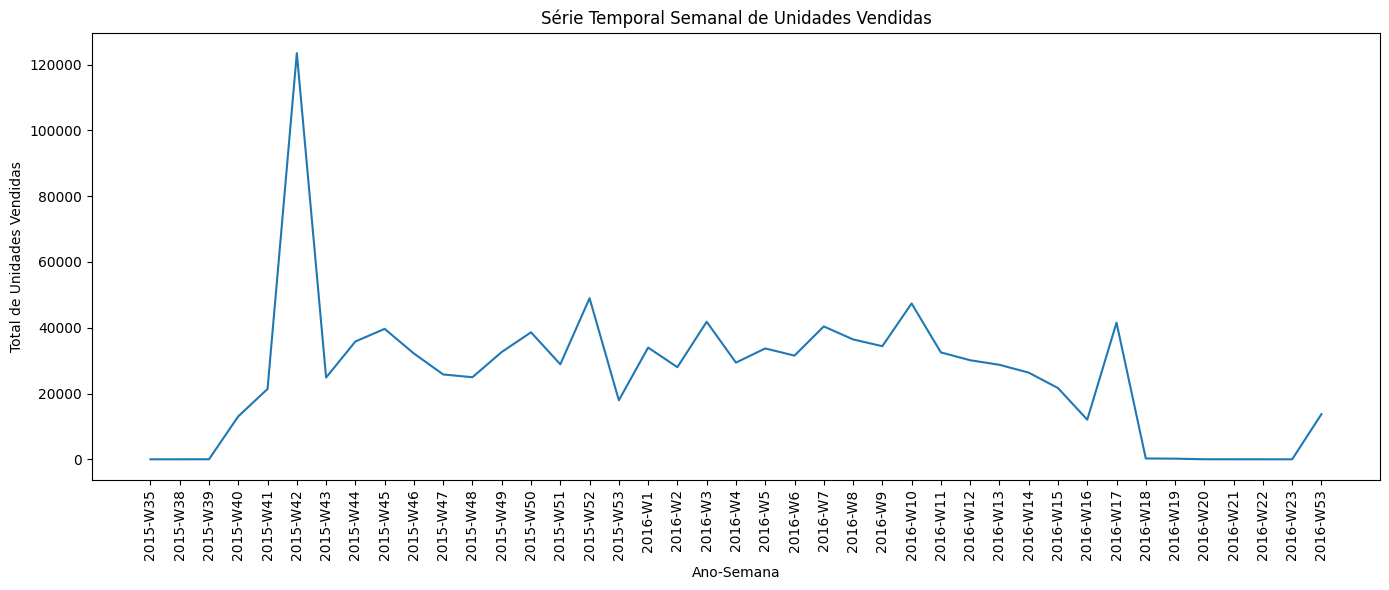

In [0]:
# Executa a query da série temporal semanal
df_semana = spark.sql("""
SELECT
    year(sale_date) AS ano,
    weekofyear(sale_date) AS semana,
    SUM(units_sold) AS total_unidades_vendidas
FROM workspace.default.fato_vendas_dw
GROUP BY
    year(sale_date),
    weekofyear(sale_date)
ORDER BY
    ano,
    semana
""")

# Converte para pandas
pdf = df_semana.toPandas()

# Cria um eixo temporal simples (ano-semana)
pdf["ano_semana"] = pdf["ano"].astype(str) + "-W" + pdf["semana"].astype(str)

# Plot
plt.figure(figsize=(14,6))
plt.plot(pdf["ano_semana"], pdf["total_unidades_vendidas"])
plt.xticks(rotation=90)
plt.title("Série Temporal Semanal de Unidades Vendidas")
plt.xlabel("Ano-Semana")
plt.ylabel("Total de Unidades Vendidas")
plt.tight_layout()
plt.show()

## Identificação de tendências
O Código a seguir é para tentarmos tangibilizar a existência de tendência de vendas na base que estamos tratando. Aqui trabalhamos com uma série mensal que suavisa as variações semanais, facilita comparação entre meses e permite leitura clara sobre as tendências. 

Ela responde a pergunta: "Existe uma tendência de crescimento, estabilidade ou queda nas vendas ao longo dos meses?"

- **Interpretação do resultado:**

Os meses iniciais apresentam volumes extremamente reduzidos de vendas, indicando início incompleto do período amostral. Esses valores não representam o comportamento real do negócio e devem ser analisados apenas como início da série histórica.

Entre outubro de 2015 e março de 2016 observa-se um período de vendas elevadas e relativamente estáveis, com pequenas variações mensais. Esse comportamento indica uma tendência de manutenção do volume de vendas, com picos pontuais possivelmente associados a eventos promocionais ou sazonais.

A partir de abril de 2016 observa-se uma redução no volume de vendas em relação aos meses anteriores, sugerindo uma possível mudança no comportamento da demanda ou redução da intensidade de ações comerciais.

Os meses de maio e junho de 2016 apresentam volumes drasticamente reduzidos, indicando encerramento parcial da base de dados. Esses valores não devem ser interpretados como queda estrutural nas vendas, mas como limitação temporal do conjunto de dados disponível.

- **Resumo:**

A análise da tendência mensal de vendas evidenciou um período central de estabilidade no volume de vendas entre outubro de 2015 e março de 2016, após um início incompleto da série e antes do encerramento parcial do período amostral. Esse comportamento indica que, no intervalo analisado, não houve tendência clara de crescimento ou queda sustentada, mas sim variações pontuais possivelmente influenciadas por ações promocionais e fatores sazonais.


In [0]:
%sql
SELECT
    year(sale_date) AS ano,
    month(sale_date) AS mes,
    SUM(units_sold) AS total_unidades_vendidas,
    SUM(revenue) AS receita_total
FROM workspace.default.fato_vendas_dw
GROUP BY
    year(sale_date),
    month(sale_date)
ORDER BY
    ano,
    mes;

ano,mes,total_unidades_vendidas,receita_total
2015,8,1,285.0
2015,9,28,81997.0
2015,10,211786,5.025083584829353E8
2015,11,133343,3.313860920437486E8
2015,12,163021,4.358202603573514E8
2016,1,146892,3.8718922270567405E8
2016,2,146964,3.315411555431747E8
2016,3,156518,4.039974728044171E8
2016,4,113230,2.7371203190778226E8
2016,5,486,1181816.0


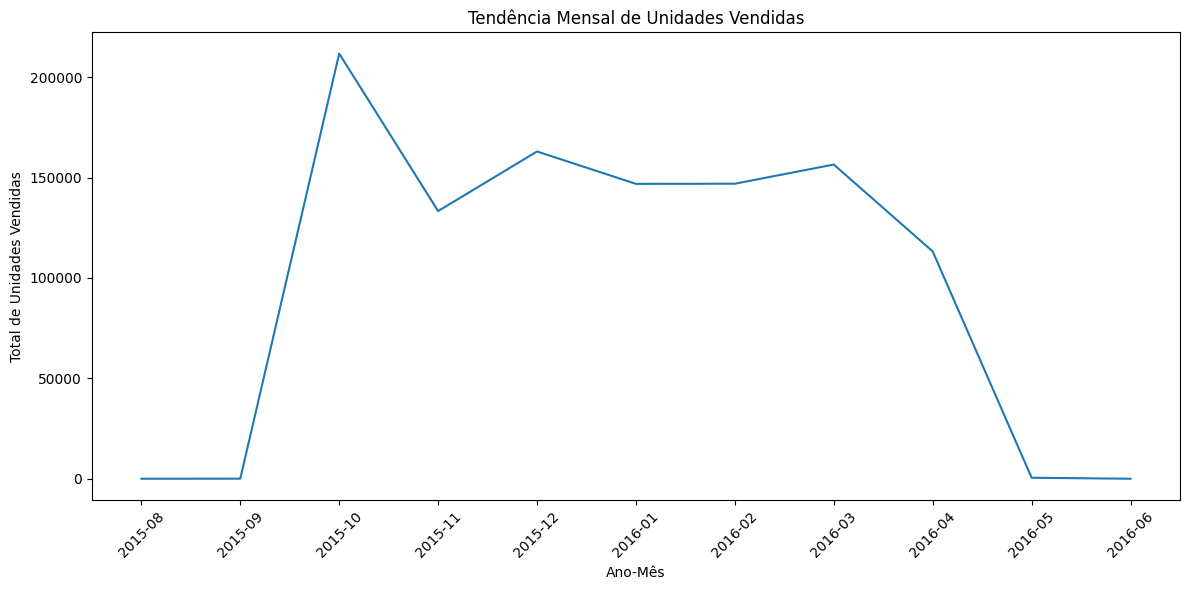

In [0]:
# Executa a query
df_mensal = spark.sql("""
SELECT
    year(sale_date) AS ano,
    month(sale_date) AS mes,
    SUM(units_sold) AS total_unidades_vendidas
FROM workspace.default.fato_vendas_dw
GROUP BY
    year(sale_date),
    month(sale_date)
ORDER BY
    ano,
    mes
""")

# Converte para pandas
pdf = df_mensal.toPandas()

# Cria eixo temporal (ano-mês)
pdf["ano_mes"] = pdf["ano"].astype(str) + "-" + pdf["mes"].astype(str).str.zfill(2)

# Plot
plt.figure(figsize=(12,6))
plt.plot(pdf["ano_mes"], pdf["total_unidades_vendidas"])
plt.xticks(rotation=45)
plt.title("Tendência Mensal de Unidades Vendidas")
plt.xlabel("Ano-Mês")
plt.ylabel("Total de Unidades Vendidas")
plt.tight_layout()
plt.show()

## Identificação de Sazonalidade
O Código a seguir é para tentarmos verificar a existência de sazonalidade nas vendas, fazer a comparação de meses idependente do ano e identificação de padrões recorrentes no comportamento de vendas. O que essa analise faz é remover o efeito do ano, consolida todos os registros do mesmo mês e calcula o comportamento médio mensal. Eu usei a média aqui, pois os meses tem quantidades de dias diferentes, a base possui meses incompletos e o objetivo é a comparação relativa e não o volume absoluto. 

Uma última explicação antes de entrarmos no resultado da análise é que julho não é apresentado nenhum venda pois não temos registros de vendas nesse mês, a base vai de agosto de 2015 até junho de 2016. 

- **Interpretação do resultado:**

Valores variam aproximadamente entre 1.01 e 1.03 unidades. A média de unidades vendidas por registro apresenta variação muito pequena entre os meses, indicando que, do ponto de vista de volume médio diário por produto, não há forte evidência de sazonalidade acentuada no dataset analisado.

Os meses de novembro e dezembro apresentam valores ligeiramente superiores de média de unidades vendidas e receita, sugerindo um possível efeito sazonal associado ao final do ano, período tradicionalmente marcado por maior consumo e campanhas promocionais no varejo.

Os meses de junho e agosto apresentam médias significativamente inferiores às demais, reflexo da baixa quantidade de registros nesses períodos, conforme identificado nas análises de tendência e série temporal. Esses valores não devem ser interpretados como comportamento sazonal negativo, mas como consequência da incompletude temporal da base de dados.

Os demais meses apresentam comportamento bastante homogêneo, reforçando a conclusão de que o dataset não evidencia uma sazonalidade forte no volume médio de vendas, mas sim variações pontuais possivelmente associadas a ações promocionais específicas.

- **Resumo:**

A análise de sazonalidade indicou que o volume médio de vendas apresenta comportamento relativamente estável ao longo dos meses, sem evidência de sazonalidade acentuada. Observam-se leves aumentos nos meses de novembro e dezembro, compatíveis com o contexto varejista, enquanto meses com valores atípicos refletem limitações temporais da base. De forma geral, os resultados sugerem que variações mais significativas no desempenho de vendas estão mais associadas a eventos específicos, como promoções, do que a padrões sazonais recorrentes.

In [0]:
%sql
SELECT
    month(sale_date) AS mes,
    AVG(units_sold) AS media_unidades_vendidas,
    AVG(revenue) AS media_receita
FROM workspace.default.fato_vendas_dw
GROUP BY
    month(sale_date)
ORDER BY
    mes;

mes,media_unidades_vendidas,media_receita
1,1.0217792029827282,2693.2841501218973
2,1.0201724305488067,2301.4421659552036
3,1.0210581251223172,2635.510945295956
4,1.016025986145508,2456.04996148543
5,1.0125,2462.116666666667
6,1.0,449.0
8,1.0,285.0
9,1.0,2928.464285714286
10,1.0223305657462831,2444.2375734253064
11,1.0241319191096843,2560.033466030226


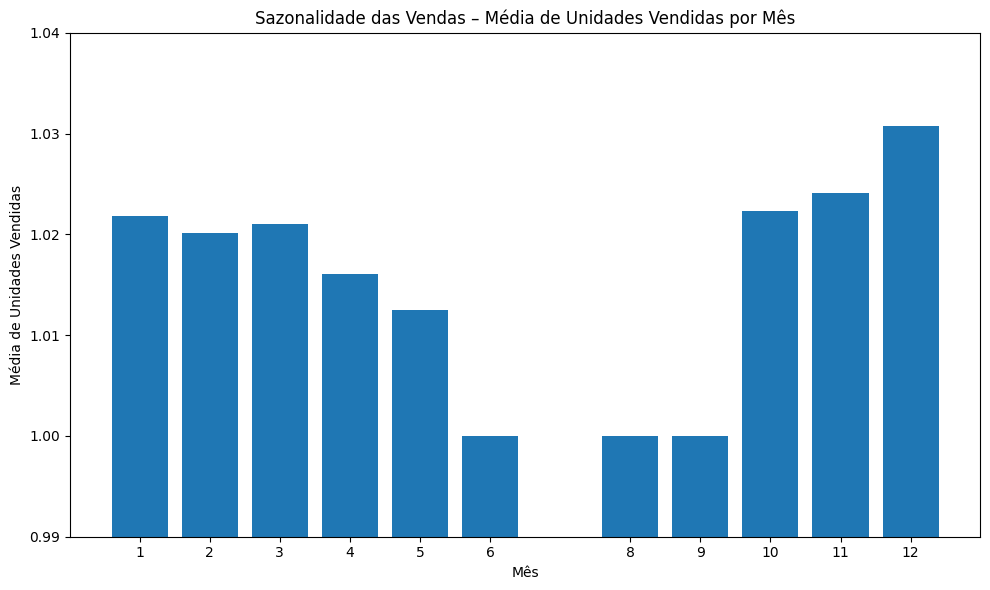

In [0]:
# Executa a query de sazonalidade
df_sazonalidade = spark.sql("""
SELECT
    month(sale_date) AS mes,
    AVG(units_sold) AS media_unidades_vendidas
FROM workspace.default.fato_vendas_dw
GROUP BY
    month(sale_date)
ORDER BY
    mes
""")

# Converte para pandas
pdf = df_sazonalidade.toPandas()

# Plot
plt.figure(figsize=(10,6))
plt.bar(pdf["mes"], pdf["media_unidades_vendidas"])
plt.title("Sazonalidade das Vendas – Média de Unidades Vendidas por Mês")
plt.xlabel("Mês")
plt.ylabel("Média de Unidades Vendidas")
plt.xticks(pdf["mes"])
plt.ylim(0.99, 1.04)  # <-- ajuste fino do eixo Y
plt.tight_layout()
plt.show()

## Comparação de vendas antes e depois de campanhas promocionais

O Objetivo dessa parte do código é fazer uma comparação entre períodos promocionais e não promocionais. É avaliado volume médio de vendas, receita média, volume total e receita total e por fim, fazer uma análise dos efeitos das campanhas. Para isso foi criado "promotion_flag" quando este é igual a 1, significa que o dia teve campanha, quando não, significa que o dia não teve. 

Quero responder a pergunta: Em média e no total, as vendas se comportam de forma diferente em dias com promoção?

- **Intepretação do resultado:**

Temos que a distribuição de dias durante a promoção foram 35 e dias sem promoção foram 215 dias isso significa dizer que o número de dias promocionais representa uma fração relativamente pequena do período analisado, indicando que as campanhas foram eventos pontuais e não contínuos ao longo do tempo.

Quando comparamos o volume médio vendido: Durante a promoção foi 1.0237 e fora da promoção foi 1.0222, apresentando diferença mínima entre os períodos promocionais e não promocionais, indicando que as campanhas não geraram aumento relevante no volume médio diário de vendas. 

Comparação da receita média, durante a promoção ~3.042 e fora da promoção ~2.386. Apesar do volume médio vendido permanecer praticamente estável, a receita média durante períodos promocionais é significativamente superior à observada fora das campanhas. Esse comportamento sugere que as promoções podem estar associadas a maior valor transacionado por venda, possivelmente devido à concentração de vendas em produtos de maior valor ou à intensificação do consumo durante esses períodos. Não assumimos nenhum desconto, apenas resultado. 

Falando de impacto total acumulado: Total de unidades vendidas durante a promoção é 268.225 e fora de promoção é 804.045. A receita total é durante o período de promoção ~794 milhões e fora da promoção é ~1.87 bilhão. Embora os períodos não promocionais concentrem maior volume total de vendas e receita, esse resultado é explicado pela maior quantidade de dias sem campanha. Assim, a análise por médias é mais adequada para avaliar o impacto relativo das promoções. 

- ** Resumo:**

A comparação entre períodos promocionais e não promocionais indica que as campanhas não geraram aumento significativo no volume médio de unidades vendidas, mas estiveram associadas a um aumento relevante na receita média por período. Esse resultado sugere que as promoções, no contexto do dataset analisado, não ampliaram substancialmente a quantidade vendida, mas contribuíram para maior valor financeiro transacionado, possivelmente por meio da concentração de vendas ou mudanças no mix de produtos durante as campanhas.

In [0]:
%sql
SELECT
    promotion_flag,
    COUNT(DISTINCT sale_date) AS dias,
    AVG(units_sold) AS media_unidades_vendidas,
    AVG(revenue) AS media_receita,
    SUM(units_sold) AS total_unidades_vendidas,
    SUM(revenue) AS receita_total
FROM workspace.default.fato_vendas_dw
GROUP BY
    promotion_flag;

promotion_flag,dias,media_unidades_vendidas,media_receita,total_unidades_vendidas,receita_total
1,35,1.0237048401993787,3042.4381390604826,268225,7.940946089236203E8
0,215,1.022228409493987,2385.662186000339,804045,1.873324531921464E9


In [0]:
%sql
WITH vendas_com_promocao AS (
    SELECT
        sale_date,
        units_sold,
        revenue,
        promotion_flag
    FROM workspace.default.fato_vendas_dw
),

janela AS (
    SELECT
        sale_date,
        units_sold,
        revenue,
        promotion_flag,
        CASE
            WHEN promotion_flag = 1 THEN 'Durante Promoção'
            WHEN promotion_flag = 0 THEN 'Fora Promoção'
        END AS periodo
    FROM vendas_com_promocao
)

SELECT
    periodo,
    AVG(units_sold) AS media_unidades_vendidas,
    AVG(revenue) AS media_receita
FROM janela
GROUP BY periodo;

periodo,media_unidades_vendidas,media_receita
Durante Promoção,1.0237048401993787,3042.438139060483
Fora Promoção,1.022228409493987,2385.662186000338


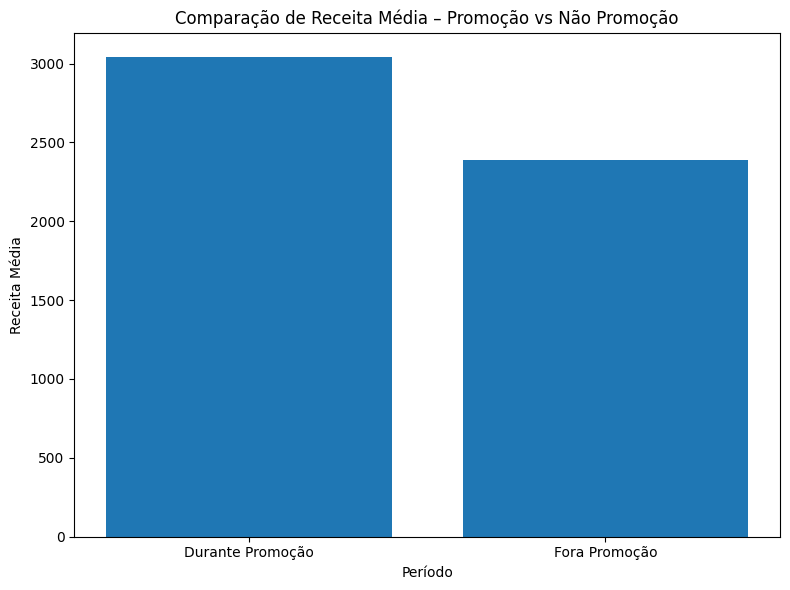

In [0]:
#Conclusão do gráfico: O gráfico evidencia que, embora o volume médio de unidades vendidas permaneça praticamente constante entre períodos promocionais e não promocionais, a receita média é significativamente superior durante as campanhas. Essa visualização reforça os resultados obtidos na análise tabular, indicando que as promoções estão associadas a maior valor financeiro transacionado por período.

# Executa a query de promoção vs não promoção
df_promo = spark.sql("""
SELECT
    CASE 
        WHEN promotion_flag = 1 THEN 'Durante Promoção'
        ELSE 'Fora Promoção'
    END AS periodo,
    AVG(revenue) AS media_receita
FROM workspace.default.fato_vendas_dw
GROUP BY promotion_flag
""")

# Converte para pandas
pdf = df_promo.toPandas()

# Plot
plt.figure(figsize=(8,6))
plt.bar(pdf["periodo"], pdf["media_receita"])
plt.title("Comparação de Receita Média – Promoção vs Não Promoção")
plt.xlabel("Período")
plt.ylabel("Receita Média")
plt.tight_layout()
plt.show()


#Conclusão final do trabalho: 

Este trabalho apresentou a aplicação completa de um projeto de Engenharia de Dados sobre o dataset DT MART: Market Mix Modeling, contemplando todas as etapas do ciclo analítico, desde a coleta e ingestão dos dados até a modelagem, análise de qualidade e solução do problema proposto.

A arquitetura adotada seguiu a metodologia medalhão, com dados brutos na Camada Bronze, dados tratados e integrados na Camada Prata e dados modelados e governados na Camada Ouro, assegurando padronização, rastreabilidade e confiabilidade das informações. A modelagem em Esquema Estrela permitiu organizar os dados de forma analítica, facilitando consultas e interpretações orientadas ao negócio.

A análise de qualidade dos dados demonstrou que a Tabela Fato apresenta elevado nível de consistência e completude, com poucas ressalvas que não comprometem os objetivos analíticos do estudo. Essa etapa garantiu que as análises subsequentes fossem conduzidas sobre uma base confiável.

Na etapa de solução do problema, a análise da série temporal semanal e mensal indicou um período central de estabilidade no volume de vendas, sem evidência de tendência clara de crescimento ou queda sustentada. A análise de sazonalidade revelou ausência de padrões sazonais fortes no volume médio de vendas, com variações discretas entre os meses e leve aumento no final do ano, compatível com o contexto varejista.

Por fim, a comparação entre períodos promocionais e não promocionais mostrou que as campanhas não geraram aumento relevante no volume médio de unidades vendidas, mas estiveram associadas a um aumento significativo na receita média por período. Esse resultado sugere que as promoções, no contexto analisado, contribuíram mais para o aumento do valor financeiro transacionado do que para a expansão do volume vendido.

De forma geral, o projeto demonstrou como técnicas de Engenharia de Dados, aliadas a análises exploratórias e consultas analíticas, podem transformar dados brutos em informações estruturadas e insights relevantes para a tomada de decisão, atendendo plenamente aos objetivos propostos neste estudo.